# Assumptions and Snails

This dataset is about abalone snails.  Resources about the data can be found [here](https://archive.ics.uci.edu/ml/datasets/Abalone).

In [5]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [7]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


cols = [
    "Sex",
    "Length",
    "Diameter",
    "Height",
    "Whole_Weight",
    "Shucked_Weight",
    "Visecra_Weight",
    "Shell_Weight",
    "Rings",
]
abalone = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/1GwCnxFT4Sd6iZDj07kNNhEREr7OJQnGvtxd67b5AMio/export?format=csv",
    names=cols,
)

<IPython.core.display.Javascript object>

In [8]:
abalone.shape

(4177, 9)

<IPython.core.display.Javascript object>

In [9]:
abalone.head()

,Sex,Length,Diameter,Height,Whole_Weight,Shucked_Weight,Visecra_Weight,Shell_Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


<IPython.core.display.Javascript object>

In [10]:
abalone.describe()

,Length,Diameter,Height,Whole_Weight,Shucked_Weight,Visecra_Weight,Shell_Weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


<IPython.core.display.Javascript object>

In [11]:
abalone.isnull().mean()

Sex               0.0
Length            0.0
Diameter          0.0
Height            0.0
Whole_Weight      0.0
Shucked_Weight    0.0
Visecra_Weight    0.0
Shell_Weight      0.0
Rings             0.0
dtype: float64

<IPython.core.display.Javascript object>

## Linearity

If we want to model our data with a linear model, we're assuming that there's a linear relationship.  As you will often see, we can sort of play around with this one by doing transformations to our inputs.  For example we can easily model $y = x^2$ with a linear model by squaring $x$ before inputting it into our model and making the relationship linear.  Squaring is the goto example for this type of transformation to linearity, but remember some other transforms we've looked at like square root and log.

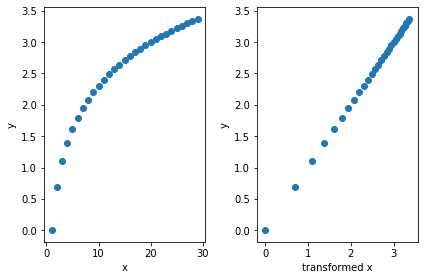

<IPython.core.display.Javascript object>

In [20]:
# (un)comment different transformations to learn the
# shape that these type relationships have in scatterplots
# fmt: off
def transform(x):
#     return np.sqrt(x)
    return np.log(x)
#     return x**2
# fmt: on


X = np.arange(1, 30)
y = transform(X)

fig, axes = plt.subplots(1, 2)

axes[0].scatter(X, y)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

axes[1].scatter(transform(X), y)
axes[1].set_xlabel("transformed x")
axes[1].set_ylabel("y")

plt.tight_layout()
plt.show()


Looking into our abalone snails dataset what linear relationships do we see?  Which ones do you think we could make linear with a transform?

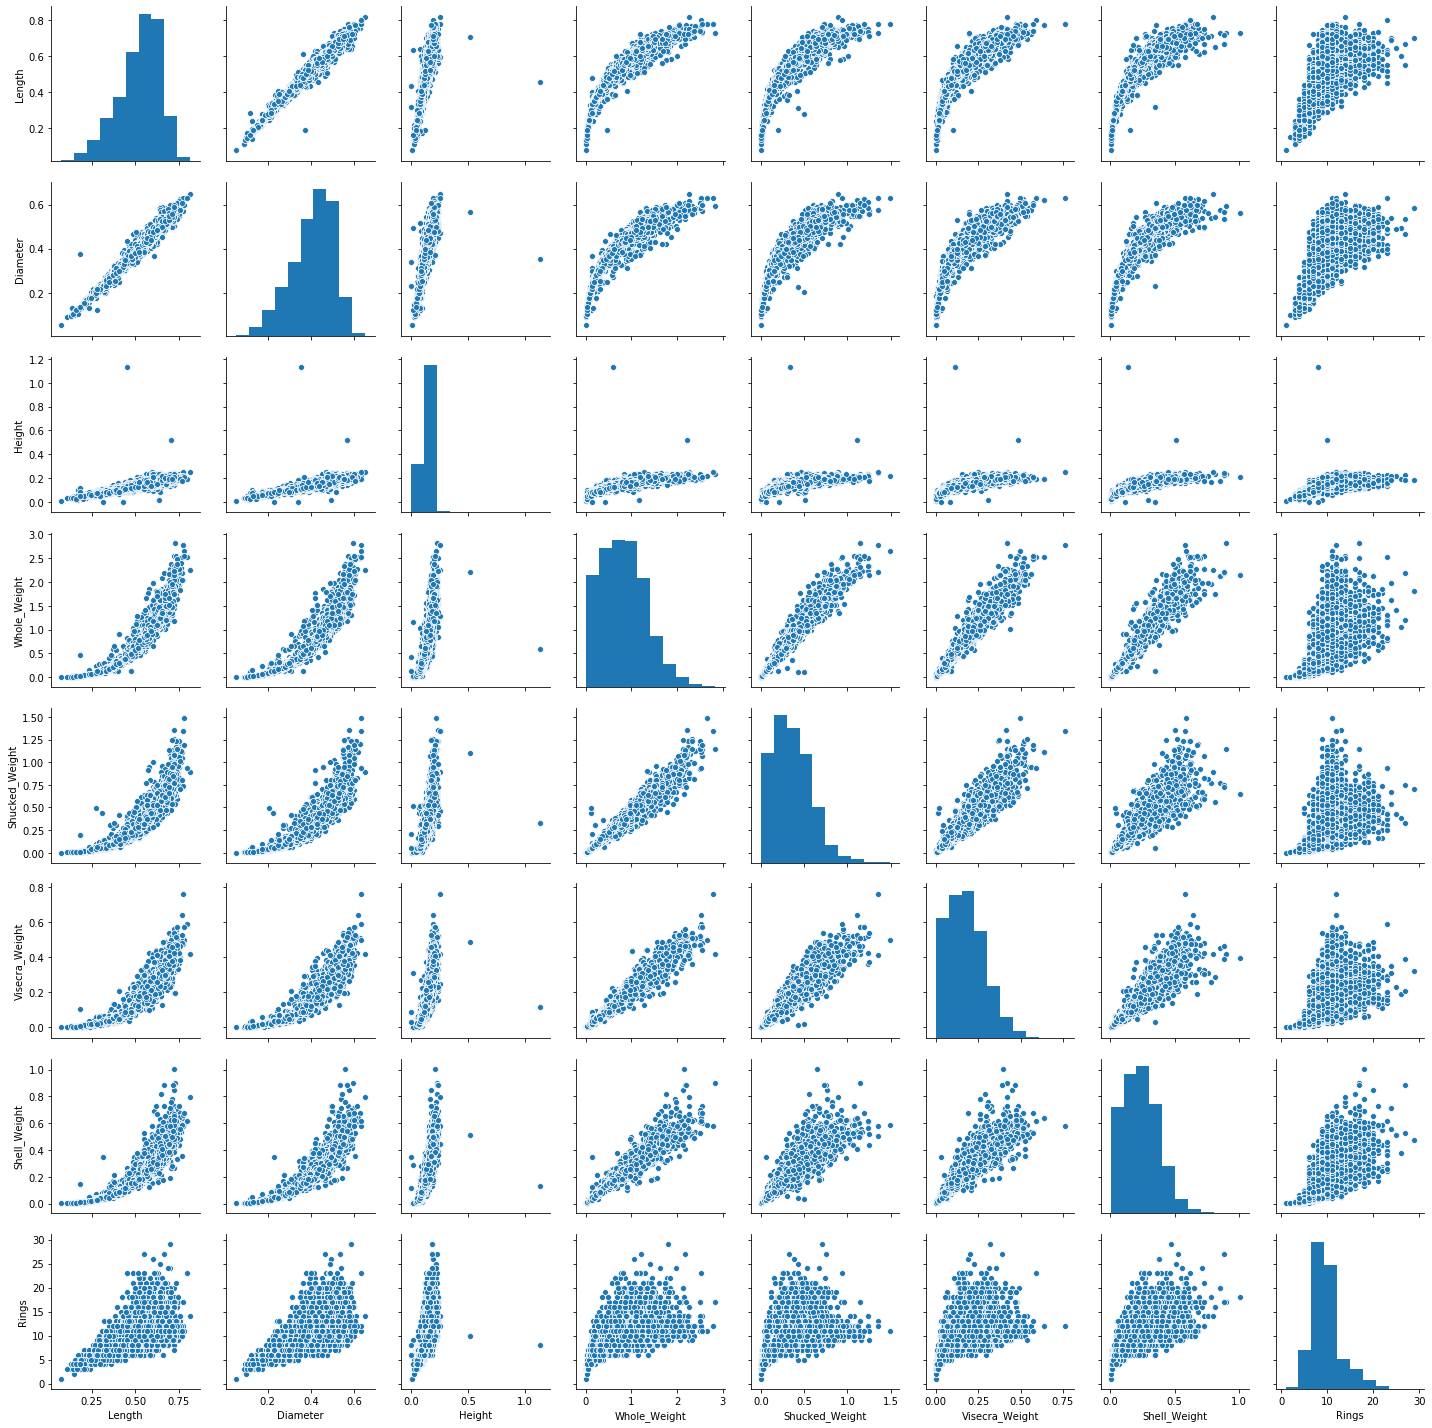

<IPython.core.display.Javascript object>

In [13]:
sns.pairplot(abalone)
plt.show()

## Error has a mean of 0

Nothing to add to what's in [the reading](https://courses.thinkful.com/dsbc-regression-problems-v1/checkpoint/3).  Just know that this is referring the theoritical error term that you see written out in formulas.  In practice our mistakes are more formally referred to as 'residuals', these residuals are essentially guaranteed to have a mean of 0 due to how the algorithms (like OLS) fit the model.

## Homoscedasticity

Big fancy hard to read word that means "same variance".  In short, we don't want our errors to have any pattern to them.  The whole reason we're modeling is to capture as many patterns and use these patterns to make accurate predictions.  If we have a pattern to our errors, we should find a way to include this pattern in the model.

Below we'll look at an example with `'Length'` and `'Rings'`.  Looking at the scatter plot between the 2 variables we see:
  1. They're positively correlated
      * The longer the snail the more rings; makes sense
  2. The longer the snail the more variation in ring count there is
      * This also makes some sense.  Short snails only have so much room to make rings, so they have a smaller range of outcomes; longer snails have more potential for diversity of ring count.
      
Number 2 should raise a red flag that we'll likely end up with heteroscedastic errors (aka our errors will get worse the longer the snail).  Let's prove this out.

Below we see that our model fits the data as best as it can.  By using transparency we can see that the line might be a little bit biased towards overpredicting (i.e. the most dense/opaque clumps of points are below the line).

In [22]:
X = abalone["Length"]
y = abalone["Rings"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

<IPython.core.display.Javascript object>

In [23]:
# Add a constant for the intercept
# This will work but throw a warning.. to silence the warning you can pass X.values instead
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_train)

<IPython.core.display.Javascript object>

In [30]:
# model = LinearRegression()
# model.fit(X_train, y_train)

<IPython.core.display.Javascript object>

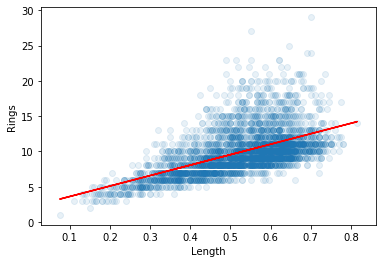

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Rings   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     1532.
Date:                Mon, 06 Apr 2020   Prob (F-statistic):          3.54e-276
Time:                        13:23:03   Log-Likelihood:                -7989.9
No. Observations:                3341   AIC:                         1.598e+04
Df Residuals:                    3339   BIC:                         1.600e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1176      0.204     10.405      0.000       1.719       2.517
Length        14.8258      0.379     39.144      0.000      14.083      15.568
==============================================================================
Omnibus:                     1110.274   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3584.376
Skew:                           1.691   Prob(JB):                         0.00
Kurtosis:                       6.784   Cond. No.                         10.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [28]:
lm_results = sm.OLS(y_train, X_train_const).fit()
y_pred = lm_results.predict(X_train_const)

plt.scatter(X_train, y_train, alpha=0.1)
plt.plot(X_train, y_pred, c="red")
plt.xlabel("Length")
plt.ylabel("Rings")
plt.show()

lm_results.summary()

Now let's look at some residual plots, which is where we actually diagnose problems with homoscedasticity.  We look at residuals because we'll typically be working in higher dimensions than 2d (which is the only reason we were able to spot this problem this early).

We'll create a random normal sample of residuals to compare our observed residuals against. 

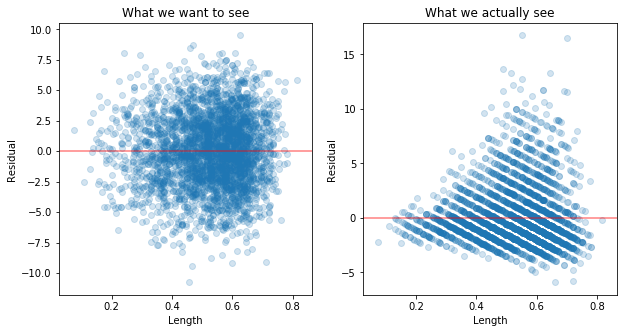

<IPython.core.display.Javascript object>

In [31]:
true_residuals = lm_results.resid
rand_norm_residuals = np.random.normal(0, 3, len(y_train))


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(X_train, rand_norm_residuals, alpha=0.2)
axes[0].axhline(0, c="red", alpha=0.5)
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Residual")
axes[0].set_title("What we want to see")

axes[1].scatter(X_train, true_residuals, alpha=0.2)
axes[1].axhline(0, c="red", alpha=0.5)
axes[1].set_xlabel("Length")
axes[1].set_ylabel("Residual")
axes[1].set_title("What we actually see")
plt.show()

We can further prove this out with a formal test if we're not convinced.  The reading shows bartlett & levene tests for this.  These test are more generic tests of variance, and in the case of checking this assumption, they are pretty sensitive and will say you're violating the assumption with slight deviations.

I recommend something more directly designed for testing this assumption.

In [32]:
# null hypothesis: data is homoscedastic
_, lmp, _, fp = het_breuschpagan(true_residuals, X_train_const)

print(f"Reject Null: {lmp < 0.05}")
print(f"Reject Null: {fp < 0.05}")

Reject Null: True
Reject Null: True


<IPython.core.display.Javascript object>

Ok... so we have a problem, we violated the homoscedasticiticity assumption. Now what... well as always, it depends.

Hopefully you're a domain expert on the data your modeling or your working with one.  Maybe there's a variable your snail scientist knows about that can lead to higher ring counts.  For example, maybe a snail's diet is a good predictor of rings and including some features about diet will capture this pattern of higher variation in longer snails.

An alternative is to try out a 'variance stabilizing transformation'.  Our whole issue is around variance so we might be able to take tackle this head on. This can might be done with `sklearn.preprocessing.power_transform()`.  In this case, it doesn't solve the issue, and is omitted.

## Multicolinearity

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = abalone[["Rings", "Shucked_Weight", "Height"]]
X = sm.add_constant(X)

# See slides for an alternative way to write this loop
# as a list comprehension.
# slides: https://docs.google.com/presentation/d/16hHE2DFrJmW7QOlPDbxOUuu-3B2Yc36l6EoIEsn75s4/edit#slide=id.p14

vifs = []
for i in range(X.shape[1]):
    vif = variance_inflation_factor(X.values, i)
    vifs.append(vif)

pd.Series(vifs, index=X.columns)

const             16.537026
Rings              1.451548
Shucked_Weight     2.504772
Height             2.990393
dtype: float64

<IPython.core.display.Javascript object>

In [43]:
X = pd.get_dummies(abalone["Sex"], drop_first=True)
X

,I,M
0,0,1
1,0,1
2,0,0
3,0,1
4,1,0
...,...,...
4172,0,0
4173,0,1
4174,0,1
4175,0,0


<IPython.core.display.Javascript object>

In [44]:
X = sm.add_constant(X)

vifs = []
for i in range(X.shape[1]):
    vif = variance_inflation_factor(X.values, i)
    vifs.append(vif)

pd.Series(vifs, index=X.columns)

const    3.195868
I        1.375609
M        1.375609
dtype: float64

<IPython.core.display.Javascript object>

In [52]:
X = abalone[["Sex", "Shucked_Weight", "Height", "Diameter"]]
y = abalone["Rings"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

ct = ColumnTransformer(
    #   Format
    #   [("name of step", what_to_do(), [what columns to do it to])]
    [("one hot encode", OneHotEncoder(drop="first"), ["Sex"])],
    remainder="passthrough",
    #     remainder=StandardScaler(),
)

ct.fit(X_train)
ct.transform(X_train)

array([[1.    , 0.    , 0.403 , 0.13  , 0.45  ],
       [0.    , 1.    , 0.497 , 0.145 , 0.425 ],
       [0.    , 1.    , 0.487 , 0.185 , 0.525 ],
       ...,
       [1.    , 0.    , 0.4285, 0.145 , 0.435 ],
       [0.    , 1.    , 0.4405, 0.18  , 0.5   ],
       [0.    , 1.    , 0.0855, 0.085 , 0.285 ]])

<IPython.core.display.Javascript object>

In [60]:
ct.transformers_[0][1].categories_

[array(['F', 'I', 'M'], dtype=object)]

<IPython.core.display.Javascript object>

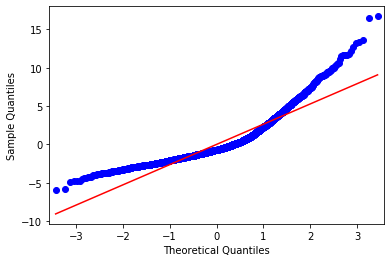

<IPython.core.display.Javascript object>

In [65]:
from statsmodels.graphics.gofplots import qqplot

qqplot(lm_results.resid, line="s")
plt.show()